# Testis Replicate 2 scRNA-Seq Bulk Cutoff

In [1]:
options(repr.plot.width=10, repr.plot.height=10)

In [2]:
DATA <- '../output/testis_cell_selection/01.01-testis_cell_selection_testis2_raw_counts.tsv'
OUTDIR <- '../output/testis2_scRNAseq'
dir.create(OUTDIR, showWarnings=FALSE)

REFERENCES_DIR <- Sys.getenv('REFERENCES_DIR')
NAME <- 'Testis2'

# Get list of mitochondiral genes
fbgn2chrom <- read.table('../output/fbgn2chrom.tsv', header=T)
fbgn2symbol <- read.csv(file.path(REFERENCES_DIR, 'dmel/r6-16/fb_annotation/dmel_r6-16.fb_annotation'), header=T, sep = '\t')[, c('gene_symbol', 'primary_FBgn')]
mito <- fbgn2chrom[fbgn2chrom$chrom == 'chrM', 'FBgn']

In [3]:
source('../lib/seurat.R')

In [4]:
library(Seurat)
library(dplyr)
library(Matrix)

Loading required package: ggplot2
Loading required package: cowplot

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave

Loading required package: Matrix

Attaching package: ‘dplyr’

The following object is masked from ‘package:Biobase’:

    combine

The following objects are masked from ‘package:BiocGenerics’:

    combine, intersect, setdiff, union

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [7]:
dat <- read.table(DATA, header=TRUE, row.names='FBgn')

In [9]:
paste('The minimum number of expressed genes in this dataset is:', min(colSums(dat > 0)))

[1] "The minimum number of expressed genes in this dataset is: 1120"

In [10]:
# Initialize the Seurat object with the raw (non-normalized data).
# Keep all genes expressed in >= 3 cells (~0.1% of the data). 
sobj <- CreateSeuratObject(raw.data = dat, min.cells = 3, project = NAME)
nCells <- dim(sobj@meta.data)[1]

# calculate the percent genes on chrom M
mask <- row.names(sobj@raw.data) %in% mito
percent.mito <- Matrix::colSums(sobj@raw.data[mask, ]/Matrix::colSums(sobj@raw.data)) * 100
sobj <- AddMetaData(object = sobj, metadata = percent.mito, col.name = "percent_mito")

In [30]:
nCells

[1] 1600

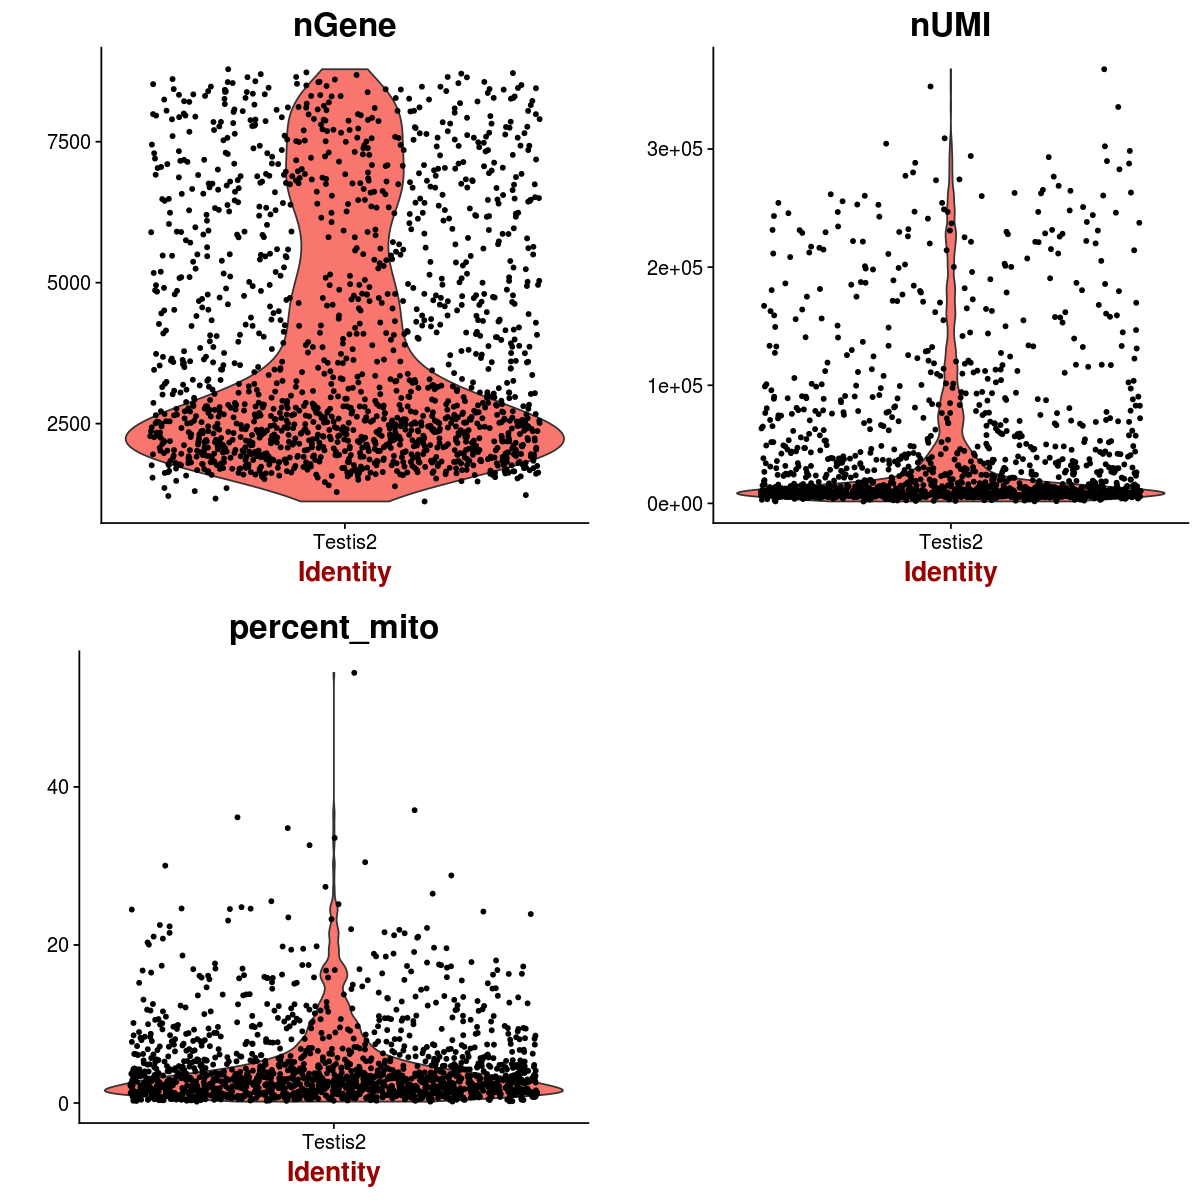

In [14]:
VlnPlot(object = sobj, features.plot = c('nGene', 'nUMI', 'percent_mito'), nCol = 2)

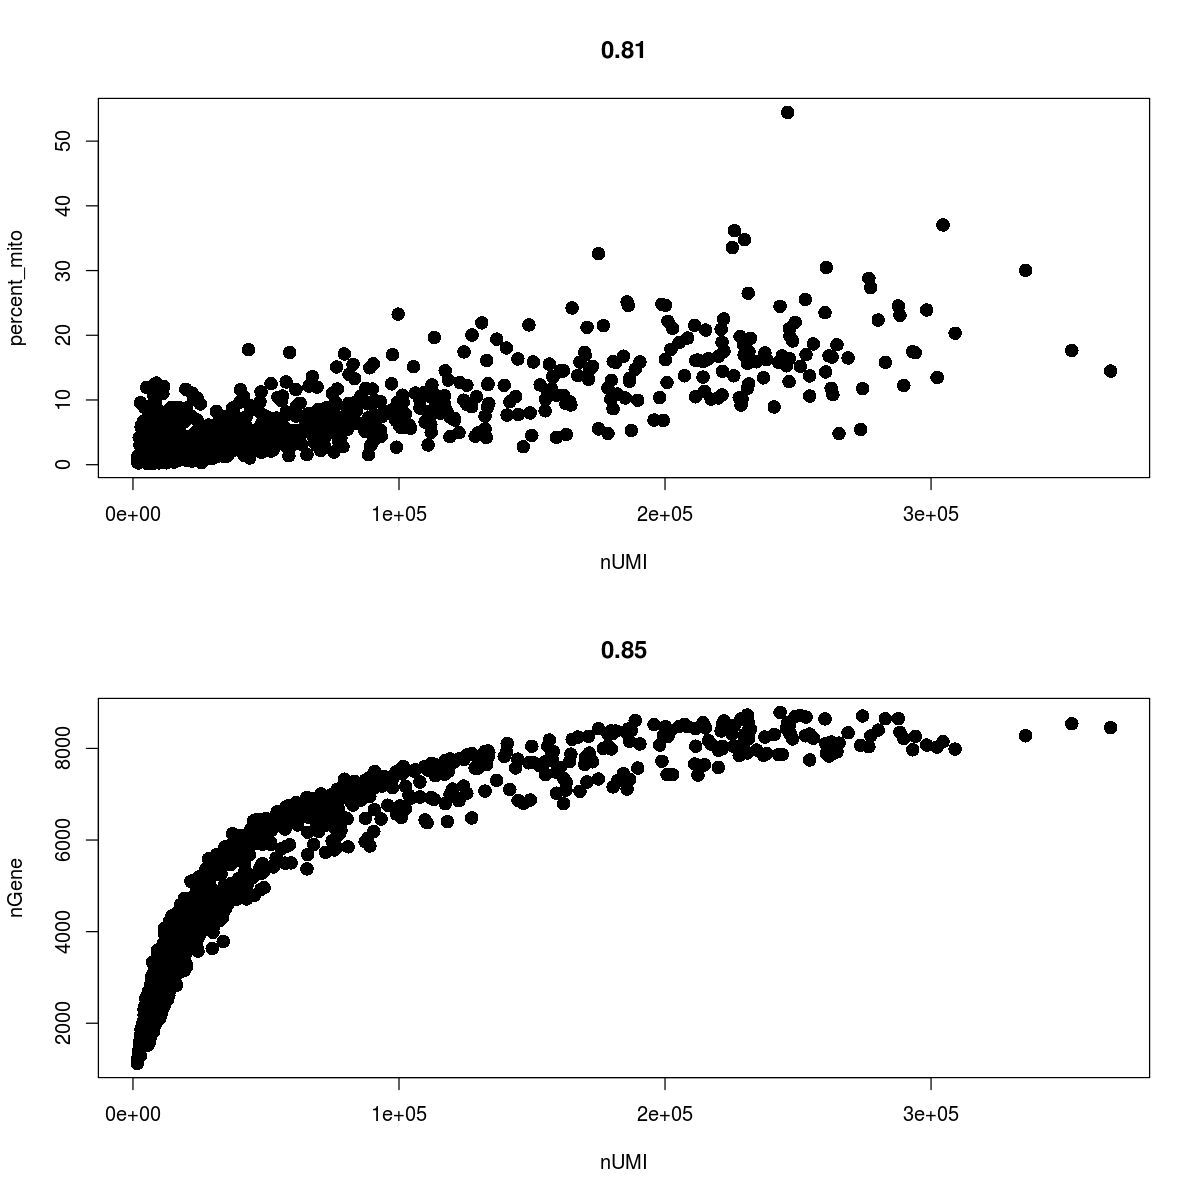

In [15]:
par(mfrow = c(2, 1))
GenePlot(object = sobj, gene1 = 'nUMI', gene2 = 'percent_mito')
GenePlot(object = sobj, gene1 = 'nUMI', gene2 = 'nGene')

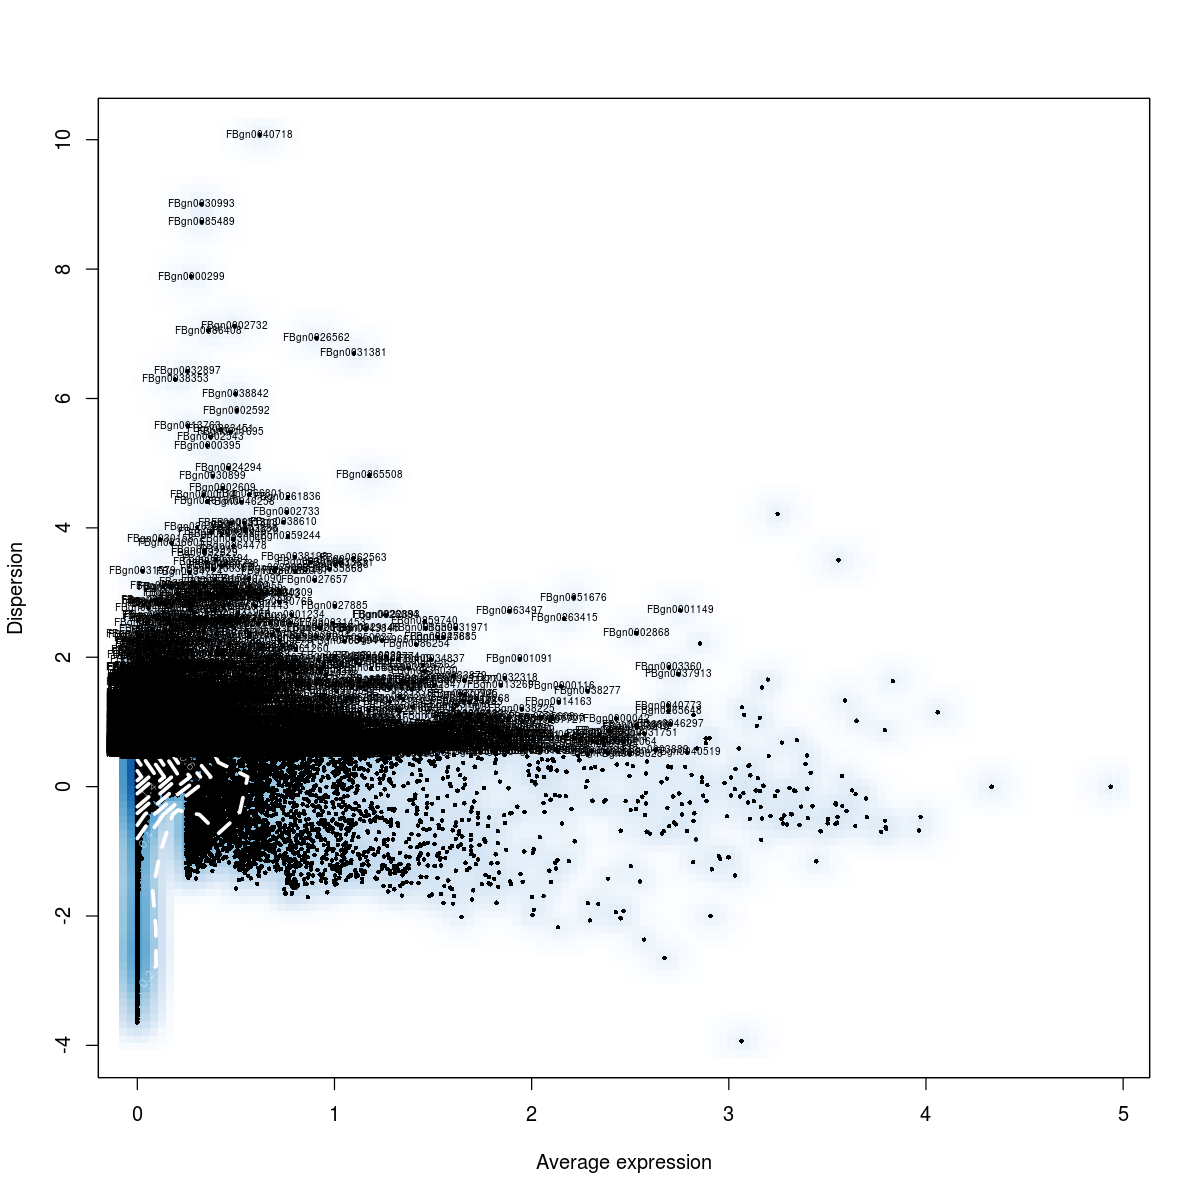

In [16]:
sobj <- NormalizeData(object = sobj, normalization.method = "LogNormalize", scale.factor = 1e4)
sobj <- FindVariableGenes(object = sobj, mean.function = ExpMean, dispersion.function = LogVMR,
                           x.low.cutoff = 0.01, 
                           x.high.cutoff = 2.8, 
                           y.cutoff = 0.5,
                           y.high.cutoff = Inf
                          )

In [18]:
length(x = sobj@var.genes)

[1] 2944

In [19]:
sobj <- ScaleData(object = sobj, vars.to.regress = c("nUMI"), display.progress = F)

In [20]:
### Perform linear dimensional reduction
sobj <- RunPCA(object = sobj, pc.genes = sobj@var.genes, do.print = FALSE, pcs.print = 1:5, genes.print = 5, pcs.compute = 100)

In [21]:
PrintPCA(object = sobj, pcs.print = 1:5, genes.print = 5, use.full = FALSE)

[1] "PC1"
[1] "FBgn0031751" "FBgn0035915" "FBgn0019828" "FBgn0003889" "FBgn0052064"
[1] ""
[1] "FBgn0000042" "FBgn0284243" "FBgn0040773" "FBgn0030733" "FBgn0014184"
[1] ""
[1] ""
[1] "PC2"
[1] "FBgn0012036" "FBgn0001149" "FBgn0027590" "FBgn0086254" "FBgn0025885"
[1] ""
[1] "FBgn0031296" "FBgn0262104" "FBgn0038277" "FBgn0034837" "FBgn0262606"
[1] ""
[1] ""
[1] "PC3"
[1] "FBgn0283451" "FBgn0002543" "FBgn0000014" "FBgn0002733" "FBgn0002609"
[1] ""
[1] "FBgn0263415" "FBgn0025373" "FBgn0032429" "FBgn0030409" "FBgn0037913"
[1] ""
[1] ""
[1] "PC4"
[1] "FBgn0265201" "FBgn0036531" "FBgn0262546" "FBgn0031483" "FBgn0264383"
[1] ""
[1] "FBgn0051676" "FBgn0035868" "FBgn0030899" "FBgn0039154" "FBgn0264478"
[1] ""
[1] ""
[1] "PC5"
[1] "FBgn0051313" "FBgn0053494" "FBgn0038610" "FBgn0032900" "FBgn0000299"
[1] ""
[1] "FBgn0029856" "FBgn0051676" "FBgn0264383" "FBgn0264478" "FBgn0029589"
[1] ""
[1] ""


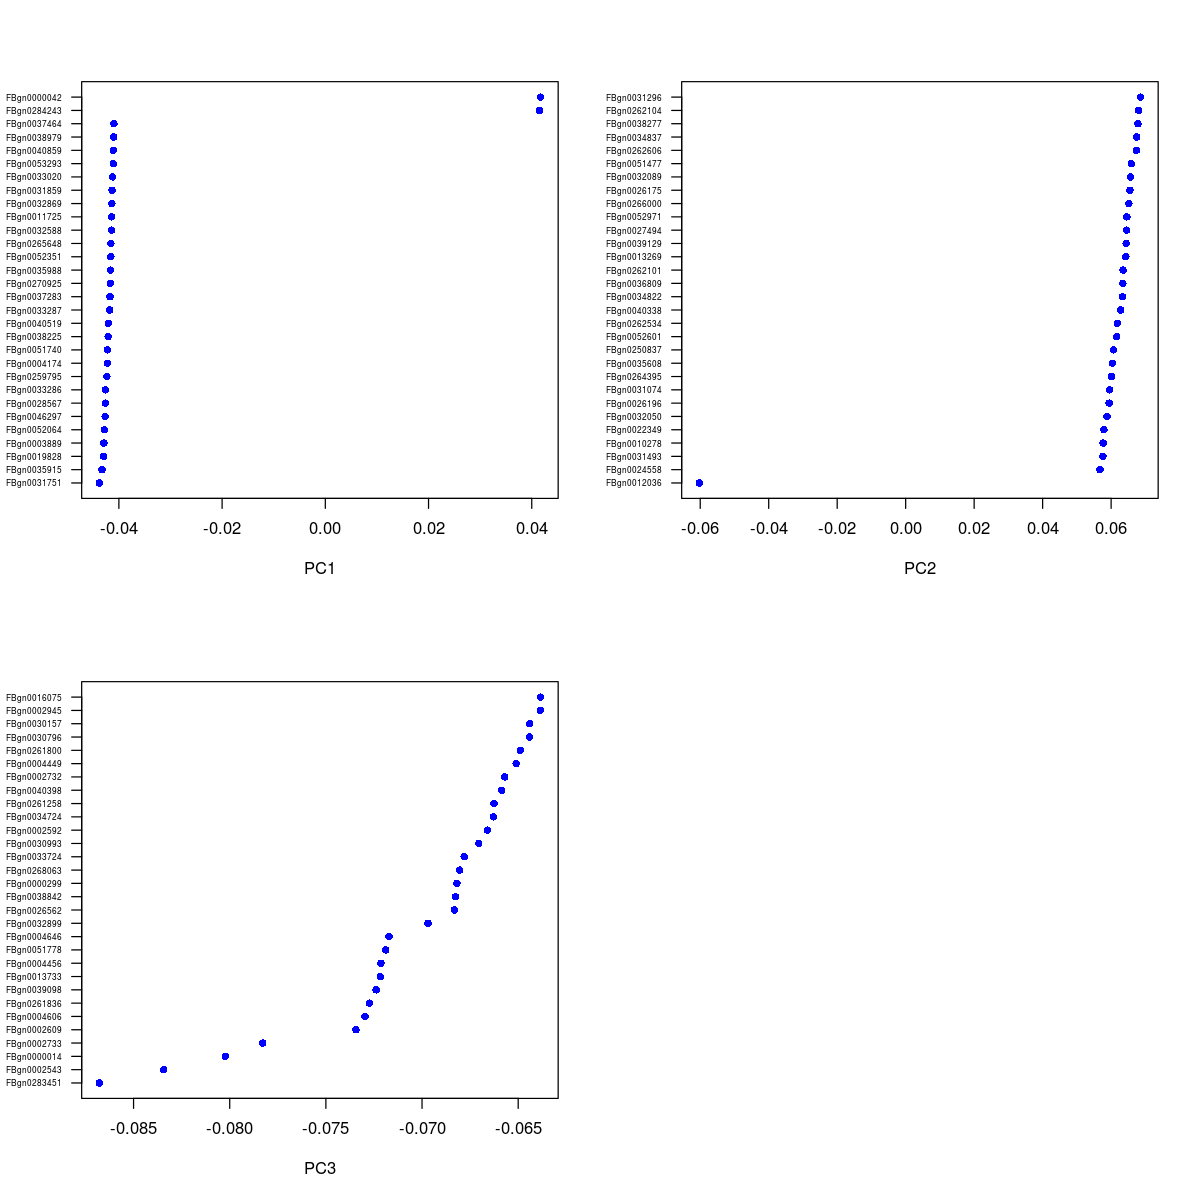

In [22]:
VizPCA(object = sobj, pcs.use = 1:3)

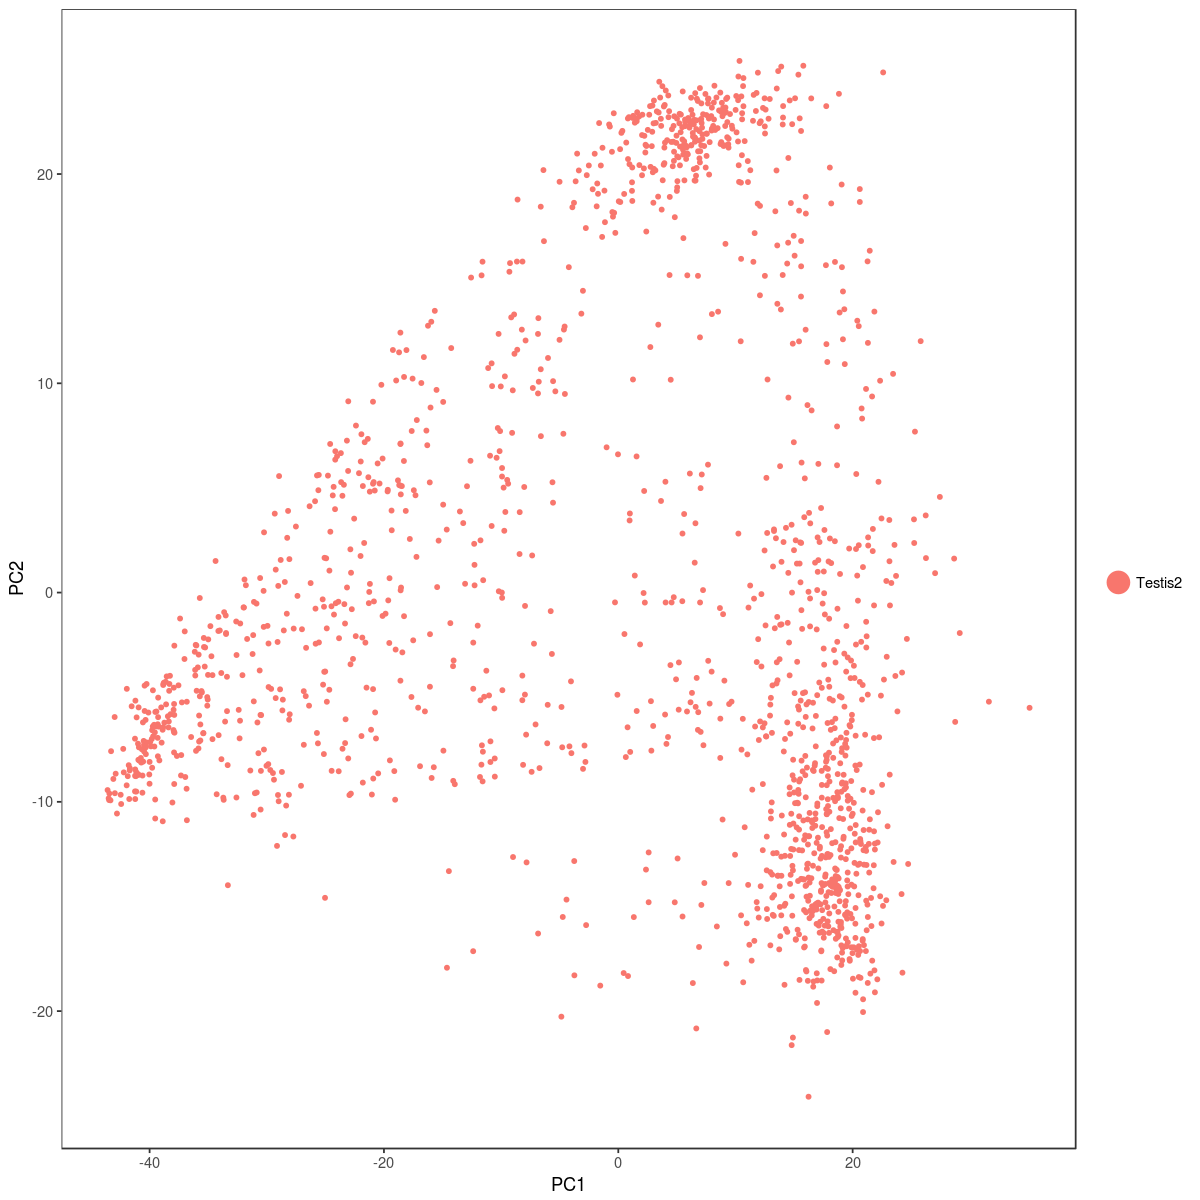

In [23]:
PCAPlot(object = sobj, dim.1 = 1, dim.2 = 2)

In [24]:
# ProjectPCA scores each gene in the dataset (including genes not included in the PCA) based on their correlation
# with the calculated components. Though we don't use this further here, it can be used to identify markers that
# are strongly correlated with cellular heterogeneity, but may not have passed through variable gene selection.
# The results of the projected PCA can be explored by setting use.full=T in the functions above
sobj <- ProjectPCA(object = sobj, do.print = F)

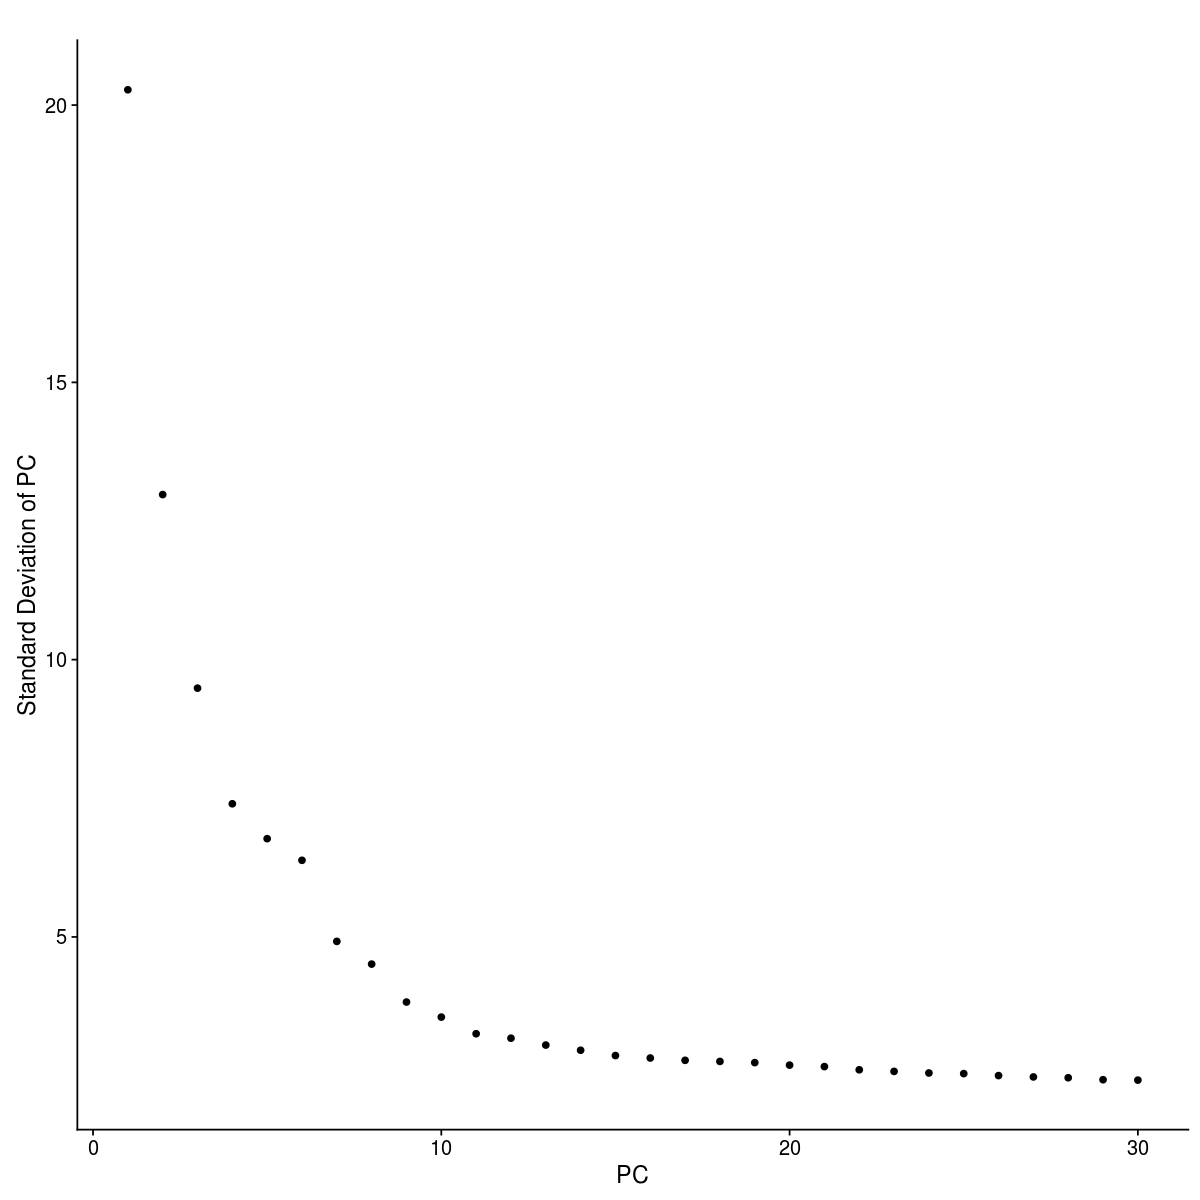

In [25]:
PCElbowPlot(object = sobj, num.pc=30)

In [26]:
sobj <- JackStraw(object = sobj, num.replicate = 100, do.print = FALSE, num.pc = 60)

Warning message:
“Removed 139952 rows containing missing values (geom_point).”

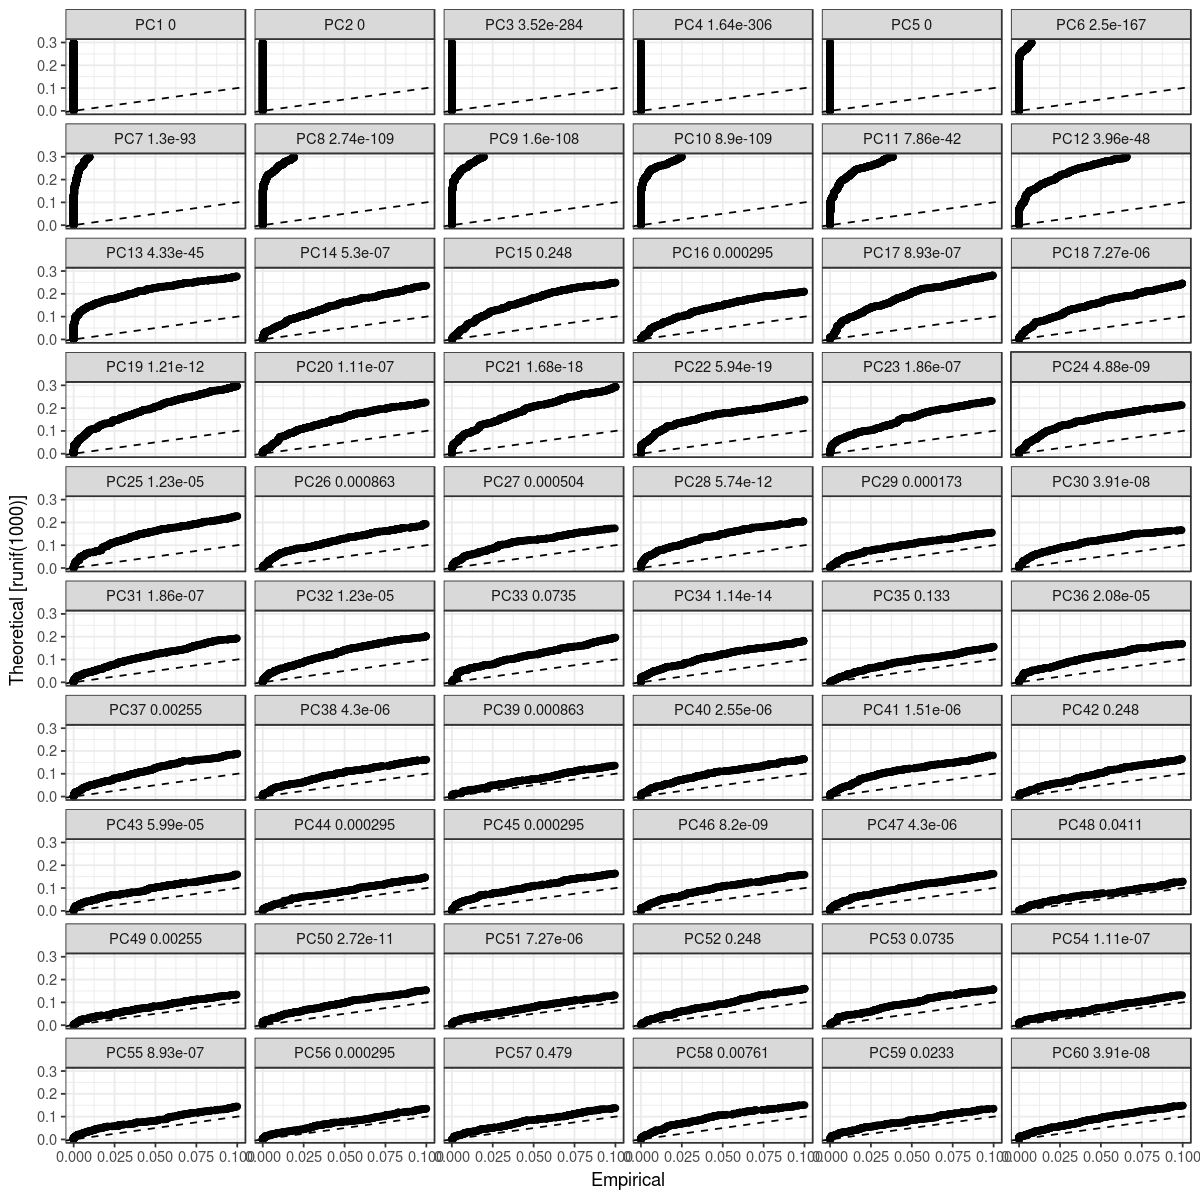

In [27]:
JackStrawPlot(object = sobj, nCol = 6, PCs = 1:60)

In [28]:
sobj <- FindClusters(
    object = sobj, 
    reduction.type = "pca", 
    dims.use = 1:32, 
    resolution = c(0.4, 0.6, 1.0, 1.2, 1.4),
    print.output = 0, 
    save.SNN = TRUE, 
)
PrintFindClustersParams(object = sobj)

Parameters used in latest FindClusters calculation run on: 2018-03-28 17:56:55
Resolution: 0.4
-----------------------------------------------------------------------------
Modularity Function    Algorithm         n.start         n.iter
     1                   1                 100             10
-----------------------------------------------------------------------------
Reduction used          k.param          k.scale          prune.SNN
     pca                 30                25              0.0667
-----------------------------------------------------------------------------
Dims used in calculation
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29
30 31 32



In [29]:
### Run Non-linear dimensional reduction (tSNE)
sobj <- RunTSNE(object = sobj, dims.use = 1:32, do.fast = TRUE)

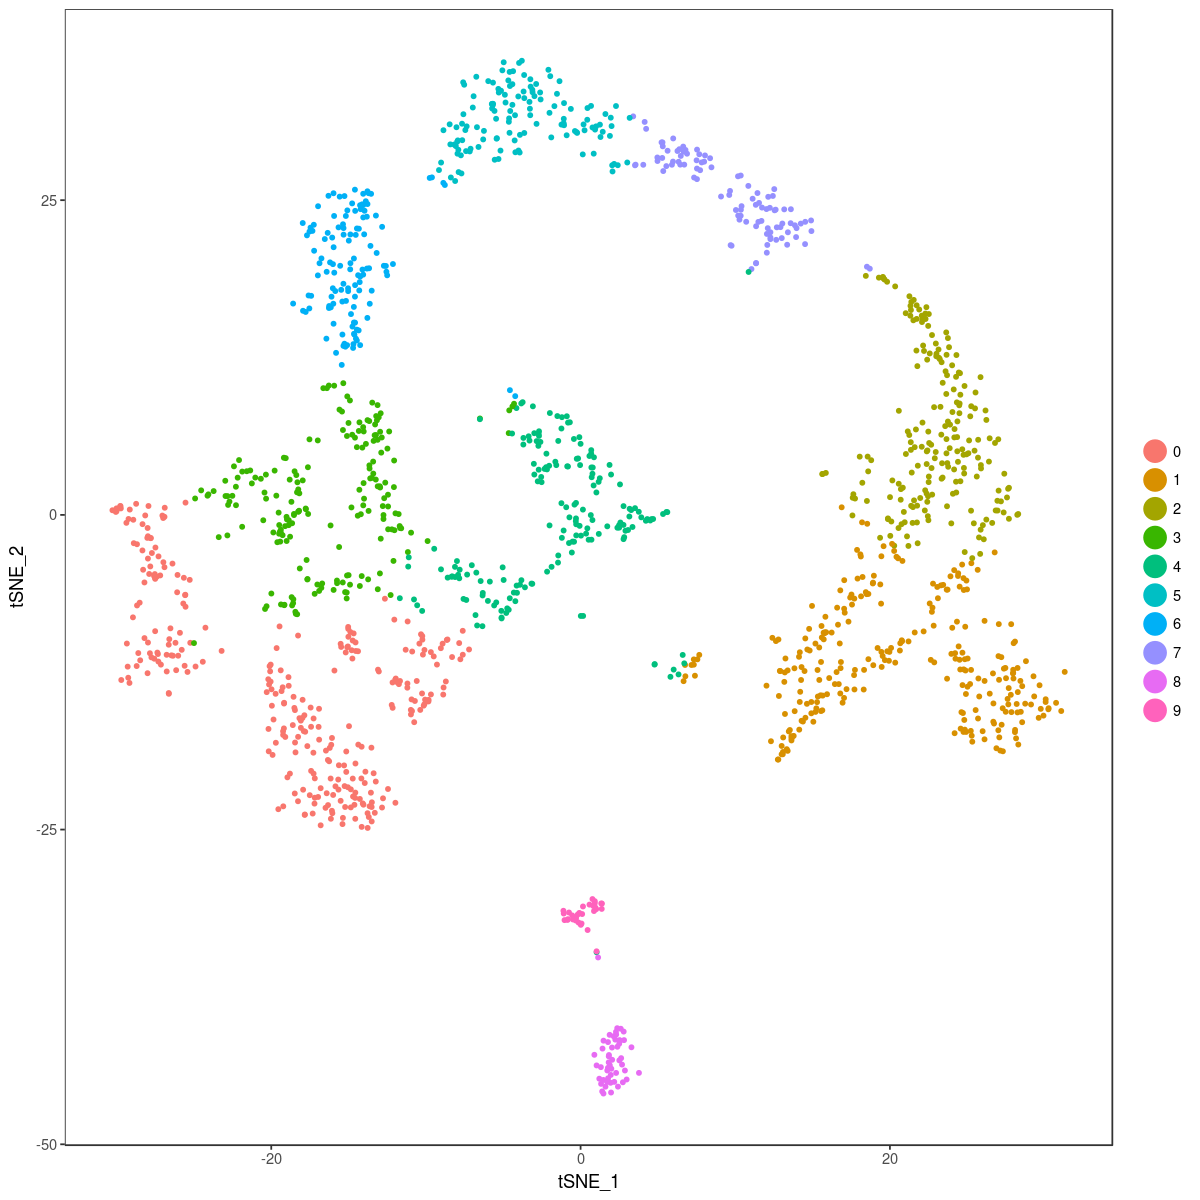

In [30]:
TSNEPlot(object = sobj, group.by='res.0.4')

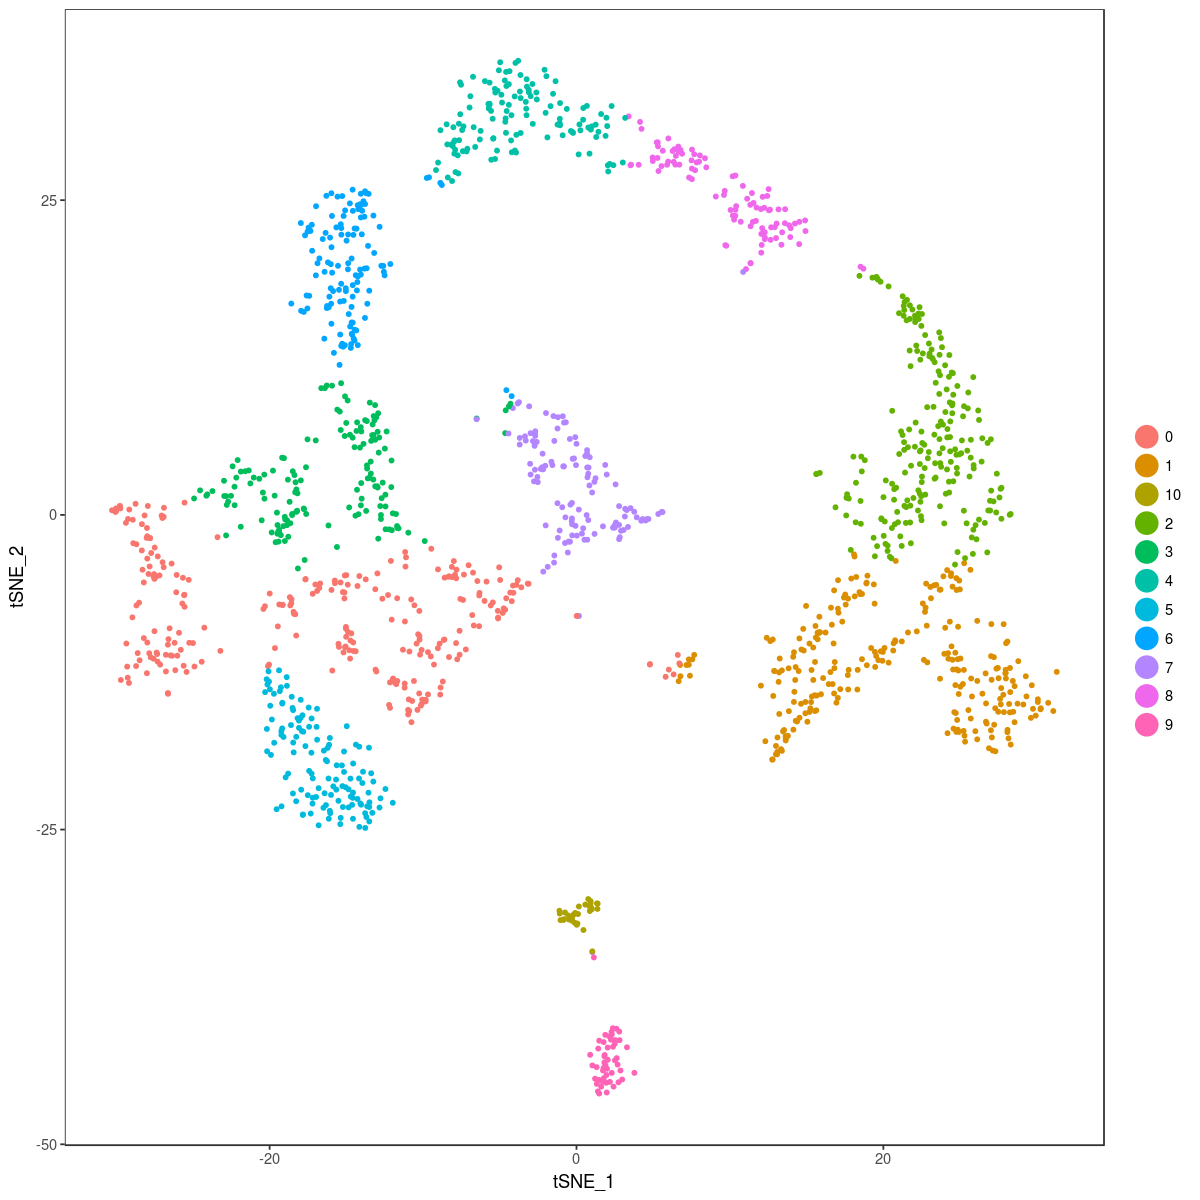

In [31]:
TSNEPlot(object = sobj, group.by='res.0.6')

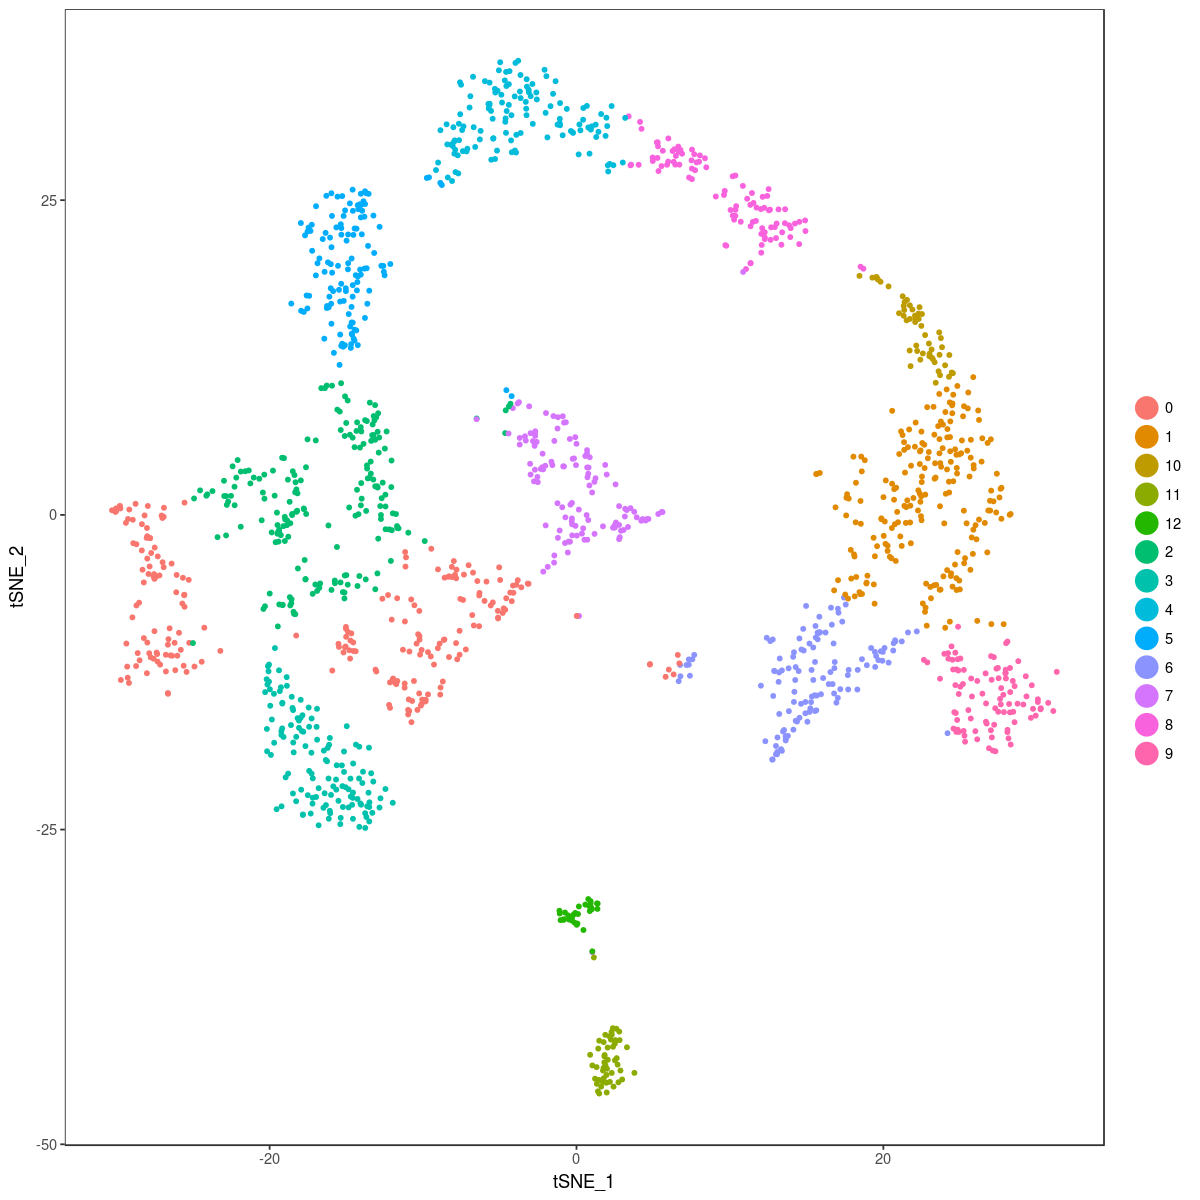

In [32]:
TSNEPlot(object = sobj, group.by='res.1')

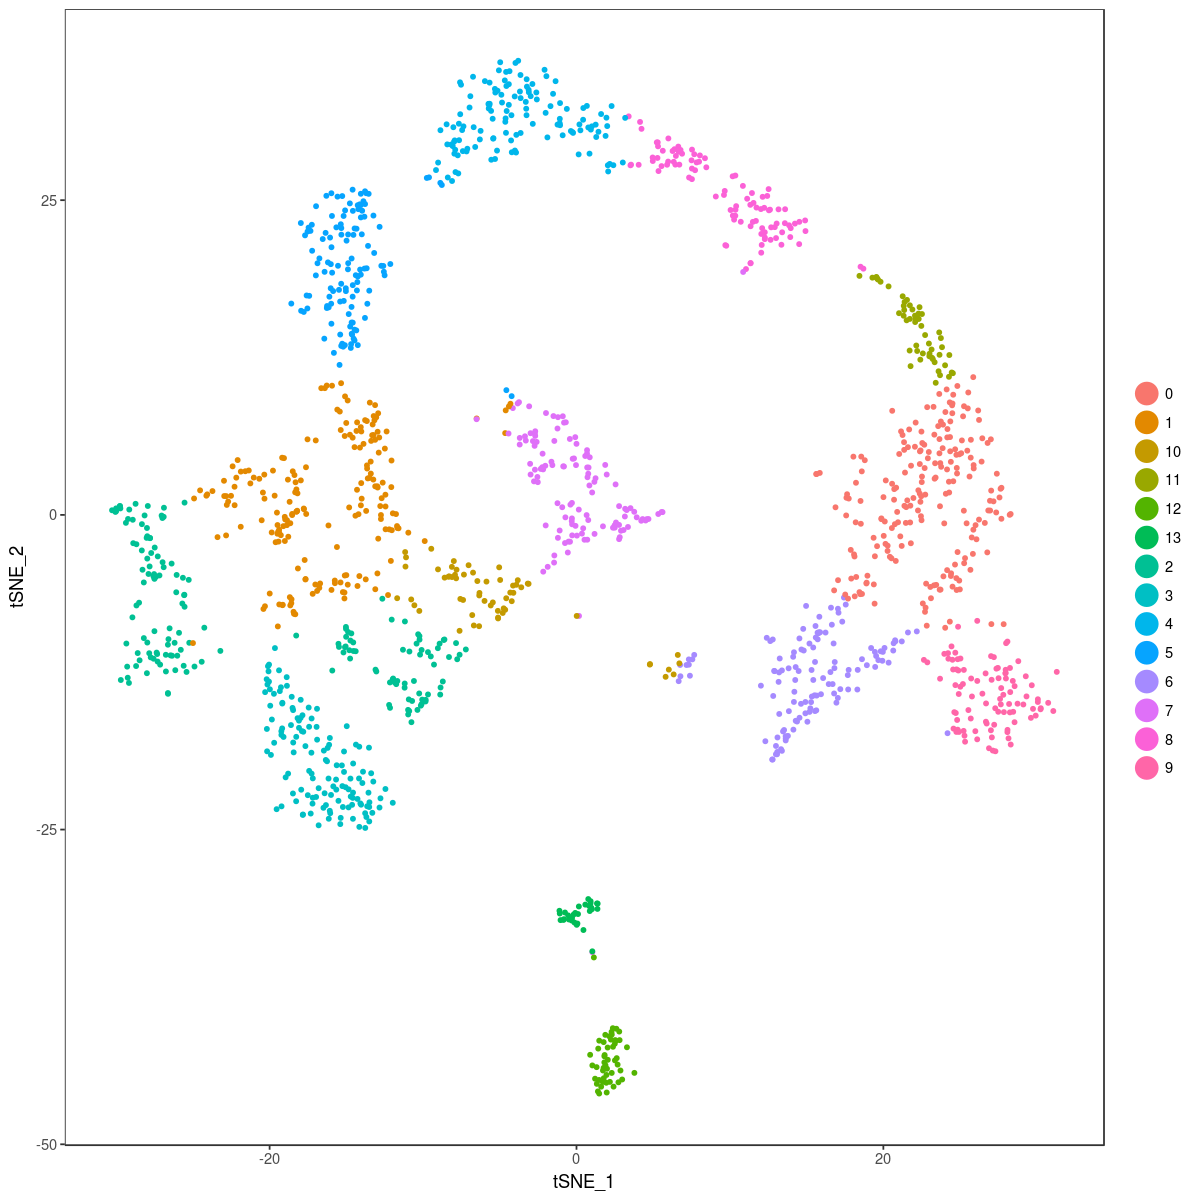

In [33]:
TSNEPlot(object = sobj, group.by='res.1.2')

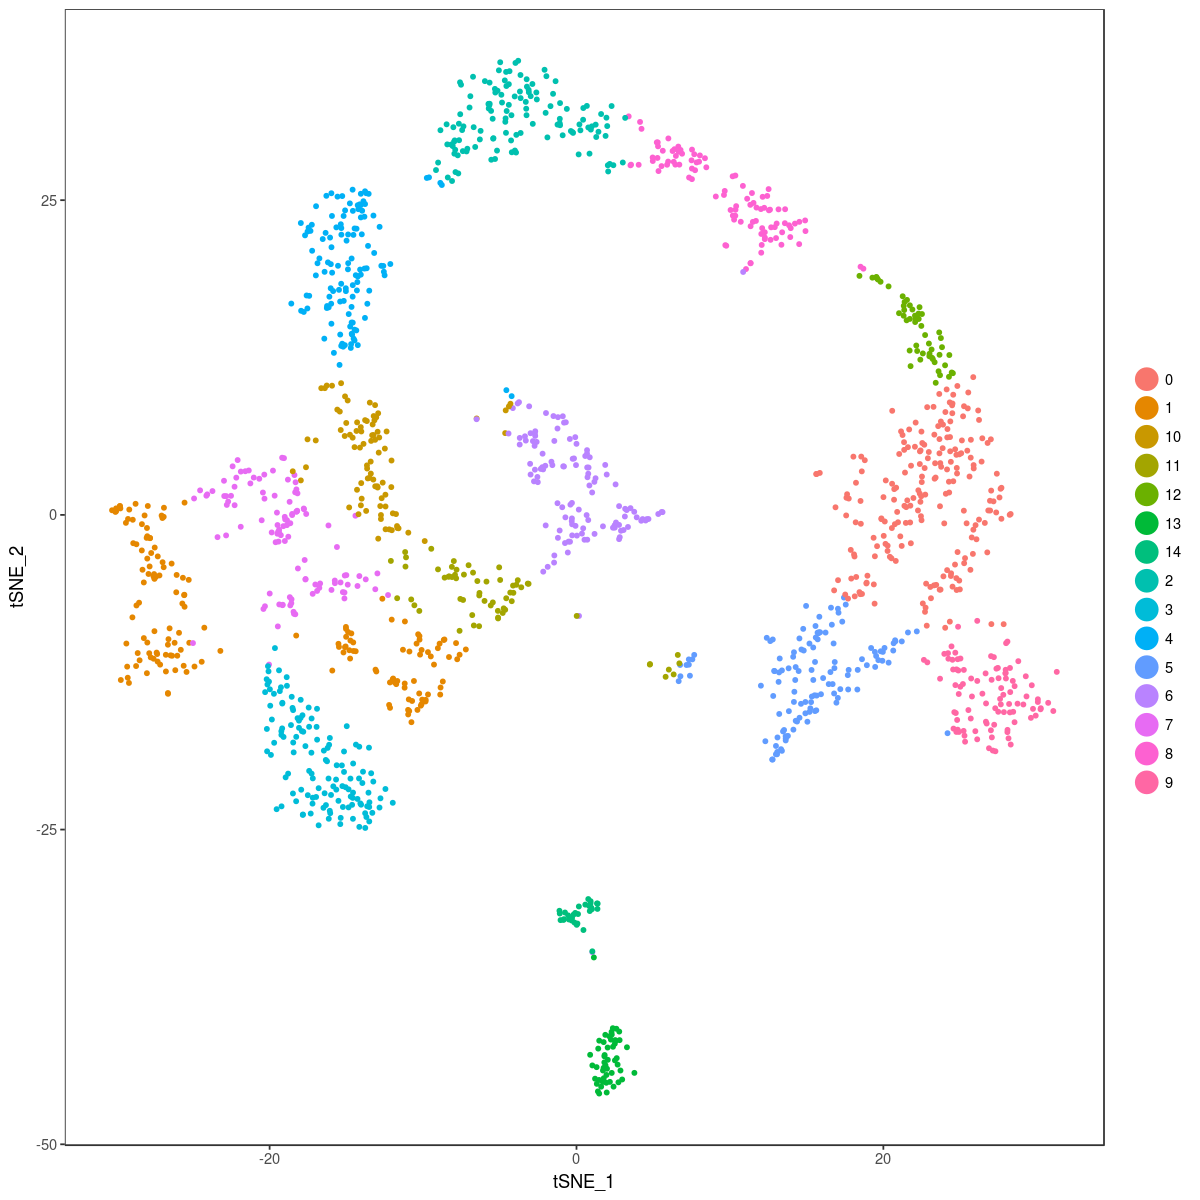

In [34]:
TSNEPlot(object = sobj, group.by='res.1.4')

In [35]:
dump_seurat(object = sobj, dir = OUTDIR)

In [36]:
# Save cluster info
params <- c(0.4, 0.6, 1.0, 1.2, 1.4)
for (i in params) {
    name <- paste0('res.', i)
    fname <- paste0('biomarkers_', i, '.tsv')
    sobj <- SetAllIdent(sobj, id = name)
    markers <- FindAllMarkers(object = sobj, only.pos = TRUE, min.pct = 0.25, thresh.use = 0.25, print.bar = FALSE)
    markers = merge(fbgn2symbol, markers, by.x='primary_FBgn', by.y='gene', all.y=T)
    save_biomarkers(markers = markers, dir = OUTDIR, fname = fname)
}